# Keras model for Posture Detection

## Defining transformers  

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
#from category_encoders.one_hot import OneHotEncoder
#from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer
#from category_encoders.ordinal import OrdinalEncoder
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings("ignore")
import ipytest.magics
import pytest
# set the file name (required)
__file__ = 'drone_pos_model.ipynb'

In [2]:
class Shuffler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        x=x.loc[np.random.permutation(x.index)]
        
        return x
############################################################################################
class XCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, x_columns):
        self.x_columns = x_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_x","leftShoulder_x","leftHip_x","rightHip_x"]].sum(axis=1)/4
        for col in self.x_columns:
            x[col] = x[col] - shift
        return x
############################################################################################
    
class YCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, y_columns):
        self.y_columns = y_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_y","leftShoulder_y","leftHip_y","rightHip_y"]].sum(axis=1)/4
        for col in list(set(self.y_columns)-set(["label"])):
            x[col] = x[col] - shift
        return x
############################################################################################

class YScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shoulder_y = x[["rightShoulder_y","leftShoulder_y"]].sum(axis=1)/2
        hip_y = x[["leftHip_y","rightHip_y"]].sum(axis=1)/2
        y_dist = hip_y - shoulder_y
        
        for col in list(set(x.columns)-set(["label"])):
            x[col] /= y_dist
        return x

## Data inspecting

In [3]:
#!pwd
#df = pd.read_csv("video_001.csv", delimiter=',')
# Christian's video is less noisy. Therefore I only train the model with his data at the moment. 
# acc increased 5 % taking his video camparing to all videos.
#path = "all_videos_posture_steptime50_checksum8160"
#path = "video_Christian_posture_steptime50_checksum8160"
path = "video_all_posture_steptime50_checksum8160"
df = pd.read_csv("../data/"+ path + ".csv",low_memory=False)
#df=df.drop([5557], axis=0)
#type(df.leftShoulder_x)
#df.info()
#print(df.dtypes)
#print()
print('labels: \n', df['label'].unique())
# we have a mix of categorical, numeric, and string data.
df.head(3)

labels: 
 [1 3 4 2 0]


,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,0.49250,0.18750,0.4000,0.18250,0.5050,0.26000,0.34375,0.19500,0.50875,0.33875,0.26625,0.16875,0.46500,0.34375,0.41125,0.34625,1
1,0.49250,0.18875,0.4025,0.18625,0.5075,0.25875,0.33250,0.19750,0.50000,0.33750,0.27625,0.17500,0.46750,0.33625,0.40875,0.33750,1
2,0.49125,0.19000,0.4025,0.17875,0.5050,0.26125,0.33500,0.19875,0.51125,0.33500,0.26375,0.16875,0.46375,0.33875,0.40875,0.33750,1


## Data cleaning

In [4]:
df1=df.dropna().drop_duplicates()
df1.shape

(3719, 17)

In [5]:
# Checking that we don't have any null values
assert df1.isnull().all().all() == False

## Non-pipline steps

In [7]:

from sklearn.model_selection import train_test_split
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(features_df, label_df, test_size=0.2, random_state=10)

In [8]:
x_train_df.shape, x_test_df.shape, y_train_df.shape, y_test_df.shape 

((2975, 16), (744, 16), (2975,), (744,))

In [9]:
x=df1.copy()
#x=x.drop(["label"], axis = 1)
x_cols = ['leftShoulder_x', 'rightShoulder_x',
        'leftElbow_x', 'rightElbow_x',
        'leftWrist_x', 'rightWrist_x',
        'leftHip_x', 'rightHip_x']
#xtrans = XCentralizer(x_cols)
#x = xtrans.transform(x)

y_cols = list(set(x.columns)-set(x_cols))
#print(y_cols)
#ytrans = YCentralizer(y_cols)
#x = ytrans.transform(x)

#ytrans = YScaler()
#x = ytrans.transform(x)
x[:2]

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,0.4925,0.18750,0.4000,0.18250,0.5050,0.26000,0.34375,0.1950,0.50875,0.33875,0.26625,0.16875,0.4650,0.34375,0.41125,0.34625,1
1,0.4925,0.18875,0.4025,0.18625,0.5075,0.25875,0.33250,0.1975,0.50000,0.33750,0.27625,0.17500,0.4675,0.33625,0.40875,0.33750,1


In [10]:
from sklearn.pipeline import make_pipeline, make_union

processing_pipeline = make_pipeline(
    XCentralizer(x_cols),
    YCentralizer(y_cols), 
    YScaler(),
    Shuffler()
    )

In [11]:
processed_df = processing_pipeline.fit_transform(x)

In [12]:
features_df = processed_df.drop("label", axis=1)
label_df = processed_df["label"]

In [13]:
%%run_pytest[clean]
def test_processingpipeline():
    # remember, this first pipeline only acts on the features, not the target.
    processed_df = processing_pipeline.fit_transform(x)
    
    # check for data leakage
    assert x.shape[0] == processed_df.shape[0]

============================= test session starts ==============================
platform darwin -- Python 3.6.5, pytest-3.5.1, py-1.5.3, pluggy-0.6.0
rootdir: /Users/lsafari/drone_steering/models, inifile:
plugins: remotedata-0.2.1, openfiles-0.3.0, doctestplus-0.1.3, arraydiff-0.2
collected 1 item

drone_pos_model.py .                                                     [100%]

=========================== 1 passed in 0.03 seconds ===========================


In [14]:
df_train = processed_df.iloc[:int(processed_df.shape[0]*0.8)]
df_val = processed_df.iloc[int(processed_df.shape[0]*0.8):]

In [15]:
assert df_train.shape[0] + df_val.shape[0] == processed_df.shape[0]

In [16]:
y_train_df = df_train['label']
x_train_df = df_train.drop('label', axis = 1)
y_val_df = df_val['label']
x_val_df = df_val.drop('label', axis = 1)
x_train=x_train_df.values
y_train=y_train_df.values
x_val=x_val_df.values
y_val=y_val_df.values

In [17]:
x_train
print("x_train=", x_train[0],"\n y_train=", y_train[0])

x_train= [ 0.22014925 -0.56343284 -0.27985075 -0.43656716  0.78731343 -0.5858209
 -0.34701493 -0.01119403  1.33208955 -0.79477612 -0.32462687  0.49626866
  0.21268657  0.48880597 -0.15298507  0.51119403] 
 y_train= 2


In [18]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

Using TensorFlow backend.


In [22]:
print(y_train[0])
print(y_val[0])

[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1.]


# Training Model

In [23]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
import matplotlib.pyplot as plt

# Model Architecture

In [24]:
from keras import models, layers
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers, losses, metrics


#default vaues
#activation="relu"
#optimizer="adam"
lr=0.01
#momentum=0
#creat model
model = models.Sequential()
model.add(layers.Dense(
        20, 
        activation="relu", 
        input_shape=(16, )))
model.add(layers.Dense(15, activation="relu"))
model.add(layers.Dense(5, activation="softmax")) #is a fast rectifier
model.summary()   

model.compile(
optimizer=optimizers.RMSprop(lr=0.01),
loss=losses.categorical_crossentropy,
metrics=["accuracy"] 
)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 80        
Total params: 735
Trainable params: 735
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=30)

Epoch 1/1000
2975/2975 [==============================] - 0s 78us/step - loss: 1.1012 - acc: 0.5896
Epoch 2/1000
2975/2975 [==============================] - 0s 46us/step - loss: 0.7281 - acc: 0.7543
Epoch 3/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.6340 - acc: 0.7956
Epoch 4/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.5745 - acc: 0.8171
Epoch 5/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.5494 - acc: 0.8229
Epoch 6/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.5145 - acc: 0.8444
Epoch 7/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.4862 - acc: 0.8461
Epoch 8/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.4777 - acc: 0.8521
Epoch 9/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.4753 - acc: 0.8548
Epoch 10/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.4450 - acc: 0.8595

2975/2975 [==============================] - 0s 42us/step - loss: 0.2641 - acc: 0.9133
Epoch 83/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2568 - acc: 0.9123
Epoch 84/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2556 - acc: 0.9173
Epoch 85/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2672 - acc: 0.9143
Epoch 86/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2610 - acc: 0.9173
Epoch 87/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2495 - acc: 0.9153
Epoch 88/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2663 - acc: 0.9190
Epoch 89/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2549 - acc: 0.9160
Epoch 90/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2564 - acc: 0.9193
Epoch 91/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.2469 - acc: 0.9213
Epoc

2975/2975 [==============================] - 0s 41us/step - loss: 0.2132 - acc: 0.9334
Epoch 163/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.2101 - acc: 0.9331
Epoch 164/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2130 - acc: 0.9271
Epoch 165/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2141 - acc: 0.9271
Epoch 166/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2152 - acc: 0.9308
Epoch 167/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2141 - acc: 0.9318
Epoch 168/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2219 - acc: 0.9277
Epoch 169/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2097 - acc: 0.9311
Epoch 170/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2135 - acc: 0.9311
Epoch 171/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.2089 - acc: 0.

2975/2975 [==============================] - 0s 41us/step - loss: 0.1959 - acc: 0.9365
Epoch 243/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2074 - acc: 0.9388
Epoch 244/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2027 - acc: 0.9345
Epoch 245/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2057 - acc: 0.9331
Epoch 246/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1979 - acc: 0.9341
Epoch 247/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2050 - acc: 0.9341
Epoch 248/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.1876 - acc: 0.9402
Epoch 249/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1854 - acc: 0.9361
Epoch 250/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2120 - acc: 0.9385
Epoch 251/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.1981 - acc: 0.

2975/2975 [==============================] - 0s 38us/step - loss: 0.1825 - acc: 0.9375
Epoch 323/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1767 - acc: 0.9405
Epoch 324/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1895 - acc: 0.9452
Epoch 325/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1823 - acc: 0.9355
Epoch 326/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1963 - acc: 0.9388
Epoch 327/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.2262 - acc: 0.9321
Epoch 328/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.2111 - acc: 0.9402
Epoch 329/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1729 - acc: 0.9418
Epoch 330/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1835 - acc: 0.9378
Epoch 331/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1842 - acc: 0.

2975/2975 [==============================] - 0s 38us/step - loss: 0.1740 - acc: 0.9432
Epoch 403/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1618 - acc: 0.9432
Epoch 404/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.1866 - acc: 0.9445
Epoch 405/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1738 - acc: 0.9439
Epoch 406/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1691 - acc: 0.9415
Epoch 407/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1744 - acc: 0.9455
Epoch 408/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1791 - acc: 0.9425
Epoch 409/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1829 - acc: 0.9398
Epoch 410/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.1825 - acc: 0.9425
Epoch 411/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1839 - acc: 0.

2975/2975 [==============================] - 0s 42us/step - loss: 0.1814 - acc: 0.9439
Epoch 483/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1811 - acc: 0.9418
Epoch 484/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1806 - acc: 0.9462
Epoch 485/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1778 - acc: 0.9455
Epoch 486/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1732 - acc: 0.9418
Epoch 487/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1758 - acc: 0.9462
Epoch 488/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1689 - acc: 0.9455
Epoch 489/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1662 - acc: 0.9439
Epoch 490/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.1646 - acc: 0.9486
Epoch 491/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1684 - acc: 0.

2975/2975 [==============================] - 0s 44us/step - loss: 0.1704 - acc: 0.9418
Epoch 563/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1562 - acc: 0.9439
Epoch 564/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.1644 - acc: 0.9516
Epoch 565/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1535 - acc: 0.9506
Epoch 566/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1547 - acc: 0.9499
Epoch 567/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1709 - acc: 0.9452
Epoch 568/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1594 - acc: 0.9506
Epoch 569/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1588 - acc: 0.9479
Epoch 570/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1706 - acc: 0.9445
Epoch 571/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1570 - acc: 0.

2975/2975 [==============================] - 0s 45us/step - loss: 0.1531 - acc: 0.9499
Epoch 643/1000
2975/2975 [==============================] - 0s 46us/step - loss: 0.1603 - acc: 0.9509
Epoch 644/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1559 - acc: 0.9496
Epoch 645/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1542 - acc: 0.9476
Epoch 646/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1605 - acc: 0.9503
Epoch 647/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1605 - acc: 0.9499
Epoch 648/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1610 - acc: 0.9442
Epoch 649/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1659 - acc: 0.9469
Epoch 650/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1668 - acc: 0.9536
Epoch 651/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1572 - acc: 0.

2975/2975 [==============================] - 0s 43us/step - loss: 0.1503 - acc: 0.9536
Epoch 723/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1648 - acc: 0.9482
Epoch 724/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1612 - acc: 0.9506
Epoch 725/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.1566 - acc: 0.9496
Epoch 726/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1534 - acc: 0.9543
Epoch 727/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1652 - acc: 0.9506
Epoch 728/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.1534 - acc: 0.9523
Epoch 729/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1720 - acc: 0.9506
Epoch 730/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1601 - acc: 0.9482
Epoch 731/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1483 - acc: 0.

2975/2975 [==============================] - 0s 39us/step - loss: 0.1516 - acc: 0.9469
Epoch 803/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1498 - acc: 0.9587
Epoch 804/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.1425 - acc: 0.9546
Epoch 805/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1444 - acc: 0.9533
Epoch 806/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1746 - acc: 0.9509
Epoch 807/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1451 - acc: 0.9519
Epoch 808/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1619 - acc: 0.9523
Epoch 809/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1446 - acc: 0.9506
Epoch 810/1000
2975/2975 [==============================] - 0s 43us/step - loss: 0.1562 - acc: 0.9492
Epoch 811/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1517 - acc: 0.

2975/2975 [==============================] - 0s 48us/step - loss: 0.1406 - acc: 0.9546
Epoch 883/1000
2975/2975 [==============================] - 0s 49us/step - loss: 0.1627 - acc: 0.9587
Epoch 884/1000
2975/2975 [==============================] - 0s 46us/step - loss: 0.1591 - acc: 0.9523
Epoch 885/1000
2975/2975 [==============================] - 0s 46us/step - loss: 0.1577 - acc: 0.9509
Epoch 886/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1556 - acc: 0.9539
Epoch 887/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1553 - acc: 0.9523
Epoch 888/1000
2975/2975 [==============================] - 0s 44us/step - loss: 0.1385 - acc: 0.9563
Epoch 889/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1451 - acc: 0.9523
Epoch 890/1000
2975/2975 [==============================] - 0s 45us/step - loss: 0.1532 - acc: 0.9539
Epoch 891/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1624 - acc: 0.

2975/2975 [==============================] - 0s 48us/step - loss: 0.1538 - acc: 0.9556
Epoch 963/1000
2975/2975 [==============================] - 0s 46us/step - loss: 0.1420 - acc: 0.9523
Epoch 964/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1369 - acc: 0.9536
Epoch 965/1000
2975/2975 [==============================] - 0s 46us/step - loss: 0.1441 - acc: 0.9519
Epoch 966/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1681 - acc: 0.9546
Epoch 967/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1512 - acc: 0.9516
Epoch 968/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1481 - acc: 0.9576
Epoch 969/1000
2975/2975 [==============================] - 0s 48us/step - loss: 0.1354 - acc: 0.9576
Epoch 970/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1452 - acc: 0.9533
Epoch 971/1000
2975/2975 [==============================] - 0s 47us/step - loss: 0.1461 - acc: 0.

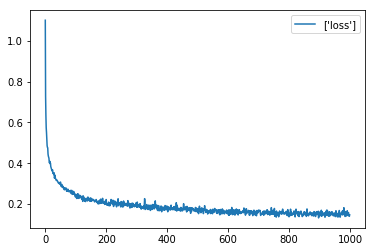

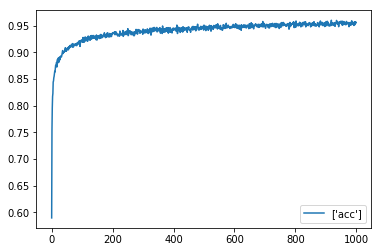

In [26]:

plt.plot(history.history["loss"], label=["loss"]) #play with hyperparameters to see the changes
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["acc"],  label=["acc"])
plt.legend()
plt.show()
plt.close()



In [27]:
test_loss, test_acc = model.evaluate(x_val, y_val)
print("Loss / Accuracy Evaluation")
print("--------------------------")
print("Loss:     " + str(round(test_loss,5)))
print("Accuracy: " + str(round(test_acc,5)))

744/744 [==============================] - 0s 40us/step
Loss / Accuracy Evaluation
--------------------------
Loss:     0.47856
Accuracy: 0.92608


In [28]:
val_y_pred = model.predict(x_val)

In [29]:
val_y_pred[10]

array([1.5722799e-05, 9.9990404e-01, 0.0000000e+00, 8.0190061e-05,
       1.8794732e-09], dtype=float32)

In [30]:
y_val[10]

array([0., 1., 0., 0., 0.], dtype=float32)

### Save Model in tensorflow.js Format

The tensorflowjs library can't be installed directly with pip / conda due to conflicting dependencies. Best is to set up a new environment explicitly for this and install tensorflowjs with the following commands:

```
pip install tensorflow==1.11.0rc2 h5py numpy keras
pip install --no-deps tensorflowjs
```

In [37]:
! pip install tensorflow==1.11.0rc2 h5py numpy keras
! pip install --no-deps tensorflowjs

  Could not find a version that satisfies the requirement tensorflow==1.11.0rc2 (from versions: 0.12.1, 1.0.0, 1.1.0rc0, 1.1.0rc1, 1.1.0rc2, 1.1.0, 1.2.0rc0, 1.2.0rc1, 1.2.0rc2, 1.2.0, 1.2.1, 1.3.0rc0, 1.3.0rc1, 1.3.0rc2, 1.3.0, 1.4.0rc0, 1.4.0rc1, 1.4.0, 1.4.1, 1.5.0rc0, 1.5.0rc1, 1.5.0, 1.5.1, 1.6.0rc0, 1.6.0rc1, 1.6.0, 1.7.0rc0, 1.7.0rc1, 1.7.0, 1.7.1, 1.8.0rc0, 1.8.0rc1, 1.8.0, 1.9.0rc0, 1.9.0rc1, 1.9.0rc2, 1.9.0, 1.10.0rc0, 1.10.0rc1, 1.10.0, 1.10.1, 1.11.0rc0, 1.11.0, 1.12.0rc0, 1.12.0rc1, 1.12.0rc2)
No matching distribution found for tensorflow==1.11.0rc2


In [35]:

! pip install --upgrade pip

    100% |████████████████████████████████| 1.3MB 3.5MB/s ta 0:00:01
  Found existing installation: pip 18.0
    Uninstalling pip-18.0:
      Successfully uninstalled pip-18.0


In [36]:
! pip install ipykernel
! pip install tensorflow_hub

In [38]:
import tensorflowjs as tfjs

In [46]:
! pwd

/Users/lsafari/drone_steering/models


In [54]:
from keras.models import load_model
import h5py

model.save('pose_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [ ]:
model.save("/")

In [53]:
tfjs.converters.save_keras_model(model, 'model_pose_tfjs')

We need to adapt the two files as follows in order for them to work on Azure:
* add a file extension .pb to the file with no extension (otherwise Azure blocks it from viewing)
* adapt the automatically generated model.json to reflect the extension .pb